## Search for a perfect cup of tea

Germans have an awesome tradition: every year you get an Adventskalender, a special calendar to count down the days in anticipation of Christmas. You can be less creative and get traditional one with sweets or go to infinity and beyond with beer, LEGO, makeup or anything your heart desires.

Last year I unexpectedly got three tea Adventskalenders: bought one for myself, one as a present at work and some from my awesome bouldering hall as a part of a price. It doesn't happen often that I have more than fifty teas to taste, so it would be a shame to miss a chance to find what makes tea awesome for me.

Simple plan: drink tea, rate it, find relations between ingredients (or their combinations) and rating. One question that I had to work out before starting was how to rate teas. I am not big fan of scales, because I find it quite hard to work out if tea tastes as 4-star-tea or 5-star-tea, even worse would be to work out a difference between 7 and 8 on scale from 1 to 10. So I ended up with a simple solution: 1 - "would buy again", 0 - "would not". It obviously has an effect on how precise my analysis is, but it was good enough, plus I could avoid "tracking fatigue".

P.S. It actually took me about two months to drink all the samples I had. During this time I have also tried some other teas, which I have included in the final dataset, though they are not originating from any christmas tea set.

P.P.S. I translate german names in text, but the dataset itself has original german words.

### Stage one: Data prep

First, parse lists of teas and their ingredients.

Obviously, I had to deal with some mess: new lines, plural forms, extra information if ingredient is bio, special characters, same things with different way to spell (Grüner Tee and Grüntee, Verbene and Verbena) ect. No data is ever clean from the beginning.

Next level of confusion was to find stuff that is almost identical, but not quite. How different are `vanilla extract` and `vanilla extract powder`? Would it affect my taste? If it seems that this one is straightforward, how about linden blossoms and linden leaves? Do leaves taste really different from flowers?

I decided to strip down parts of plants from the names, it might be some information lost, but increases sample size for distinct ingredients.

In [31]:
import itertools
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
from sklearn.feature_selection import SelectKBest, chi2

import utils

pd.set_option('display.max_rows', 50)

with open('style.json') as f:
    plt.rcParams.update(json.load(f))

In [32]:
df = utils.parse_teas_to_df(extend_feaures_n=0)
df.to_csv('teas.csv')
df_with_pairs = utils.parse_teas_to_df(extend_feaures_n=2)
df.to_csv('teas_extend_feaures.csv')

df.head()

,Ringelblumen,Zitronenmyrten,Süße Brombeer,Reiskörner,Kakaoschale,Äpfel,Rosmarin,natürliches Aroma,Echtes Goldrutenkraut,Heidekraut,...,Bachnmischung (Auszug aus Gentian [Herbstenzian],Echinaceakraut,Weißdorn,Passionsblumenkraut,Natürliches Aroma mit Apfelgeschmack,Majorankraut,Honigbuschzweigspitze,Orangen,Brombeer,Lemongras
St. Lucia,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
Sanddorn Quitte,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Glückseligkeit,0,0,0,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
Abendtee,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Motivation & Zuversicht,0,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0


I have ended up with two dataframes: one, that has teas as samples and ingredients as columns encoded as dummy variables. Second one has extended information about which pairs of ingredients were present in the tea, since i suspect, that interactions between them might have an effect on taste (if you have ever tried ice cream with fries, you know what i mean).

### Stage two: Stats, stats, stats

In [17]:
x = df[[col for col in df.columns if col != 'score']]
y = df['score']

x_extended = df_with_pairs[[col for col in df_with_pairs.columns if col != 'score']]
y_extended = df_with_pairs['score']

The chi-square is a non-parametric test, which measures dependence between stochastic variables. It tests the null hypothesis that no relationship exists on the categorical variables. Seems like a good way to work out which ~~features~~ ingredients of tea actually influence the score. There is a drawback though, chi-square is sensitive to the sample size, so the results need to be taken with a grain of salt.

Performing most of statistical tests on a small sample size should be taken sceptically, so I kept in mind some sanity checks, that would tell me that analysis makes sense: I am quite sure, that I am not a big fan of black tea and chamomile but do love cinnamon.

In [18]:
def generate_chi2_stats(x, y):
    fs = SelectKBest(score_func=chi2, k=10)
    fs.fit(x, y)
    
    df_chi = pd.DataFrame(
        index=x.columns, columns=['chi', 'p', 'n'],
        data=np.column_stack([fs.scores_, fs.pvalues_, x.sum().values])
    )
    df_chi = df_chi.sort_values(['chi'], ascending=False)
    
    return df_chi

In [19]:
df_chi = generate_chi2_stats(x, y)
df_chi.head(10)

,chi,p,n
Koriander,4.444444,0.035015,6.0
Brennnessel,4.050000,0.044171,3.0
Kamillen,4.050000,0.044171,3.0
Zitronengras,2.962963,0.085192,4.0
Fenchel süß,2.962963,0.085192,4.0
Zitronenmyrten,2.868148,0.090349,5.0
Schwarztee,2.700000,0.100348,2.0
Apfelminze,2.700000,0.100348,2.0
Hagebutte,2.288095,0.130370,7.0
Zichorien,2.222222,0.136037,3.0


I would have never guessed that coriander would influence the score so much. But it seems sensible so far, most of the tastes are something that I know that I like or hate (who likes nettles in their tea anyway?!)

In [20]:
df_chi_extended = generate_chi2_stats(x_extended, y_extended)
df_chi_extended.head(10)

,chi,p,n
Koriander,4.444444,0.035015,6.0
Brennnessel,4.050000,0.044171,3.0
"(Hibiskus, Zitronenmyrten)",4.050000,0.044171,3.0
"(Melissen, Kamillen)",4.050000,0.044171,3.0
Kamillen,4.050000,0.044171,3.0
"(Hibiskus, Sanddorn)",4.050000,0.044171,3.0
"(Honigbuschzweigspitze, Zitronenmyrten)",4.050000,0.044171,3.0
"(Hagebuttenschale, Zitronenmyrten)",4.050000,0.044171,3.0
"(Sanddorn, Zitronenmyrten)",4.050000,0.044171,3.0
"(Apfel, Hibiskus)",4.050000,0.044171,3.0


It seems that a combination of tastes highly changs the situation. Not for nettles though, I have strong opinions on this one.

Let's do some sanity checks before moving forward. Just making sure that I am not getting classical "more samples lead to more significance" problem.

In [21]:
df_chi.sort_values('n', ascending=False).head(10)

,chi,p,n
Süßholz,0.040000,0.841481,15.0
Hibiskus,0.003858,0.950473,12.0
Apfel,1.222377,0.268895,12.0
Ingwer,0.172391,0.677996,11.0
Zimtrinde,0.026667,0.870283,10.0
Brombeer,1.245185,0.264474,10.0
Zitronenmelisse,0.226852,0.633868,10.0
Anis,2.080741,0.149168,10.0
Hagebuttenschale,0.226852,0.633868,10.0
Kardamom,0.644630,0.422039,10.0


Seems like sample size is not even correlated with p-value, so we can continue.

In [22]:
df_chi.corr()

,chi,p,n
chi,1.000000,-0.841933,-0.133692
p,-0.841933,1.000000,0.325986
n,-0.133692,0.325986,1.000000


Chi-square test shows, that given ingredients have an effect on my attitude towards tea, but doesn't say if I love them or hate. Simple way to work this out is to check, which score on average I gave to teas with these ingredients. For high chi-square results it should be consistent.

In [23]:
for taste in df_chi.index[:10]:
    appears = df.loc[df[taste]==1]
    n = len(appears)
    mean = df.loc[df[taste]==1]['score'].mean()
    print(f'{taste}: mean: {mean}, sample size: {n}')

Koriander: mean: 1.0, sample size: 6
Brennnessel: mean: 0.0, sample size: 3
Kamillen: mean: 0.0, sample size: 3
Zitronengras: mean: 1.0, sample size: 4
Fenchel süß: mean: 1.0, sample size: 4
Zitronenmyrten: mean: 0.2, sample size: 5
Schwarztee: mean: 0.0, sample size: 2
Apfelminze: mean: 0.0, sample size: 2
Hagebutte: mean: 0.8571428571428571, sample size: 7
Zichorien: mean: 1.0, sample size: 3


And for low chi-square, it should be a mess:

In [24]:
for taste in df_chi.index[-10:]:
    appears = df.loc[df[taste]==1]
    n = len(appears)
    mean = df.loc[df[taste]==1]['score'].mean()
    print(f'{taste}: mean: {mean}, sample size: {n}')

Holunderbeere: mean: 0.5, sample size: 2
Hopfenzapfe: mean: 0.5, sample size: 2
Johannisbeeren schwarz: mean: 0.5, sample size: 2
Süße Brombeer: mean: 0.5, sample size: 2
Kamille: mean: 0.5, sample size: 2
Süßholz: mean: 0.6, sample size: 15
Zimtrinde: mean: 0.6, sample size: 10
Pfefferminze: mean: 0.6, sample size: 5
Grüntee: mean: 0.6, sample size: 5
Hibiskus: mean: 0.5833333333333334, sample size: 12


It is not surprising that ingredients with the highest sample size, like liquorice (Süßholz) and Rosemallows (Hibiskus) have most confusing scores, since most teas had multiple ingredients. It is probably a combination of tastes or other distinct tastes that affect the score.

Another way to work out, which features can strongly predict my attitude is to train a simple logistic regression from sklearn.

In [25]:
def select_predictors(x, y, df_chi, n_predictors):
    scores = {}
    clfs = {}
    for n in n_predictors:
        xx = x[df_chi.index[:n]]
        clf = sklearn.linear_model.LogisticRegression().fit(xx, y)
        score = clf.score(xx, y)
        # no point to have a model with more features, but same score. It's occam's razor, man
        if score not in scores.values():
            scores[n] = clf.score(xx, y)
            clfs[n] = clf
        
    fig, ax = plt.subplots()
    ax.plot(scores.keys(), scores.values())
    ax.set_ylim([0.5, 1.0])
    ax.set_xlabel('n predictors')
    ax.set_ylabel('mean accuracy')
    plt.show()
    
    return clfs[max(scores, key=scores.get)], xx

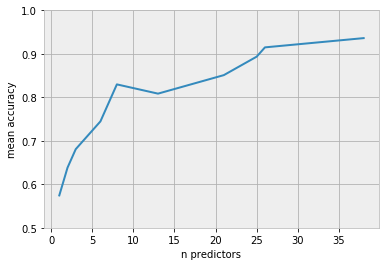

In [26]:
best_clf, features = select_predictors(x, y, df_chi, range(1, len(x)))

I know, I know, these beautiful scores are probably from overtraining and the model would not score that nice on any training set, if I had one.

In [27]:
for i, coef in enumerate(best_clf.coef_[0]):
    if abs(coef) > 0.5:
        print(f"{features.columns[i]}: {coef:.2f}")

Koriander: 0.82
Brennnessel: -0.78
Kamillen: -0.62
Zitronengras: 0.89
Fenchel süß: 0.57
Zitronenmyrten: -0.72
Schwarztee: -0.69
Apfelminze: -0.53
Zimt: 0.63
Anis: 0.70
Orangen süß: -0.72
Johannisbeer schwarz: 0.68
Rote Bete: 0.59
Grünes HAFERkraut: 0.51
Zitronen: -0.61


Results are more or less consistent with chi-square scores. And they seem quite relatable to me. Well, till it comes to beetroot. Beetroot in the tea? Why? And it seems that I even like it.

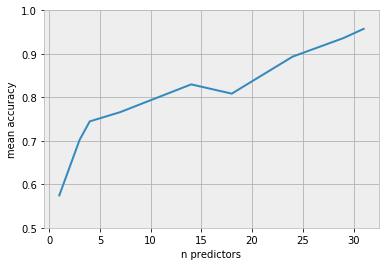

In [29]:
best_clf_extended, features_extended = select_predictors(x_extended, y_extended, df_chi_extended, range(1, len(x_extended)))

In [30]:
for i, coef in enumerate(best_clf_extended.coef_[0]):
    if abs(coef) > 0.5:
        print(f"{features_extended.columns[i]}: {coef:.2f}")

Koriander: 0.89
Brennnessel: -0.83
('Melissen', 'Kamillen'): -0.60
Kamillen: -0.60
('Honigbuschzweigspitze', 'Zitronenmyrten'): -0.60
('Hibiskus', 'Orangenschale'): 0.76
Zitronengras: 0.86
Fenchel süß: 0.63
('Zitronenmelisse', 'Brombeer'): -0.81
('Zitronenmelisse', 'Linden'): -0.55
('Blaue Malve (Käsepappel)', 'Kornblume'): -0.58
('Kornblume', 'Ringelblume'): -0.67
Schwarztee: -0.89
('Zitronenschale', 'Süßholz'): -0.77
('Orangen süß', 'Süßholz'): -0.77


While the accuracy of the model with extended features is higher, it seems less useful to me. Yes, there is some added information about which combinations work especially bad for me, but none of them contradicts with my feelings towards individual ingredients. If I don't like chamomile, it doesn't add anything to know that I also don't like it in combination with lemon balm. It would be more fun to find out the opposite, but, you know, real world data is boring.

### Result

While I definitely had fun trying different teas and playing around with the dataset and got some insights about my love to coriander and lemongrass teas, the most important question, obviously is, if am I going to mix coriander, fennel, lemongrass and cinnamon in a most-beautiful-best-ever-uber-tasty tea and enjoy it? This is worth waiting for next Christmas to find out.